# Kaggle Titanic competition
goal: create fast and submit to learn how to deal with Kaggle


In [ ]:
# general & data analysis imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing imports
from sklearn import preprocessing
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# model learning & evaluation imports
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

## data loading

In [113]:
train_dataset=pd.read_csv('train.csv')
test_dataset=pd.read_csv('test.csv')

## data analysis

In [3]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train_dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_dataset.head()


In [ ]:
train_dataset.hist(figsize=(15,20));
plt.figure();

In [ ]:
sns.pairplot(train_dataset, hue="Survived");

In [ ]:
sns.heatmap(train_dataset.corr(),annot=True) 


In [ ]:
test_dataset.isnull().sum()

## data preprocessing

In [114]:
# remove dependent variable from train set to have the same structure as test set
df_y=train_dataset['Survived'].copy()
train_dataset.drop('Survived', axis=1,inplace=True)

In [115]:
def preprocess_data(source_df):
    df=source_df.copy()
    # Age to bins, NaN to separate bin
    df.Age.fillna(-1, inplace=True)
    age_bins=(-10,0,2,16,32,500)
    age_labels=('age_unk','age_upto2', 'age_upto16','age_upto32','age_above32')
    df.Age=pd.cut(df.Age, age_bins, labels=age_labels)
    #cabin - keep first letter
    df.Cabin.fillna('Unknown', inplace=True)
    df.Cabin=df.Cabin.apply(lambda x: x[0])
    # fare - divide by mean (~32)
    df.Fare.fillna(df.Fare.median(), inplace=True)
    df.Fare=df.Fare.apply(lambda x: x/32)
    # embarked - fillna
    df.Embarked.fillna('U', inplace=True)
    # ticket, name - drop
    df=df.drop(['Ticket','Name'], axis=1)
    
    #return preprocessed df
    return df


In [116]:
df_test=preprocess_data(test_dataset)
df_train=preprocess_data(train_dataset)

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [117]:
def encode(df1, df2):
    '''df1, df2 - train and test dataframes
    return - modified df1, df2'''
    
    cat_features =['Sex','Pclass'] # features for categorization
    onehot_features=['Cabin','Embarked','Age'] # features for onehot encoding
    
    # for each feature, use LabelEncoder on both dataframes
    for f in cat_features:
        l_encoder = preprocessing.LabelEncoder()
        l_encoder.fit(df1[f])
        df1[f]=l_encoder.transform(df1[f])
        df2[f]=l_encoder.transform(df2[f])

    # use OneHotEncoder on both dataframes
    oh_encoder = ce.OneHotEncoder(handle_unknown='ignore', cols=onehot_features,use_cat_names=True)
    df1=oh_encoder.fit_transform(df1)
    df2=oh_encoder.transform(df2)
    
    return df1,df2
        
    

In [118]:
df_train, df_test = encode(df_train, df_test)

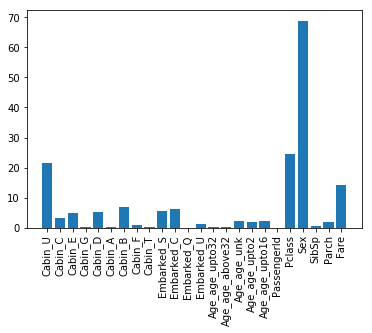

In [120]:
# Perform feature selection
predictors=df_train.columns.tolist()
selector = SelectKBest(f_classif, k=10)
X_train_pruned=selector.fit_transform(df_train, df_y)
X_test_pruned=selector.transform(df_test)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [145]:
# split train and validation
# X_train,X_val,y_train,y_val=train_test_split(df_train.values,dfy.values,test_size=0.25,random_state=1, shuffle=True)
X_train,X_val,y_train,y_val=train_test_split(X_train_pruned,df_y.values,test_size=0.25,random_state=1, shuffle=True)
X_test=X_test_pruned

In [136]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(891, 10)
(891,)
(0, 10)
(0,)
(418, 10)


## building MLP model

In [137]:
def mlp_model(units_list, l2=0):
    model=models.Sequential()
    for u in units_list:
        model.add(Dense(units=u, activation='relu',kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

In [138]:
def train_model(model,data,epochs=20,learning_rate=1e-3):
    
    X_train, y_train, X_val, y_val = data
    # Compile model with learning parameters.
    loss = 'binary_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in <patience> consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20)]

    # Train and validate model.
    history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
    #        callbacks=callbacks,
            validation_data=(X_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=128)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Plot training & validation accuracy values
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Save model.
    # model.save('titanic.h5')
    return history['val_acc'][-1], history['val_loss'][-1], model

In [139]:
my_model=mlp_model(units_list=[8,4,2],l2=0.003)

In [141]:
my_data= (X_train, y_train, X_val, y_val)
_,_,my_model=train_model(my_model,my_data,epochs=1000,learning_rate=1e-3)

Train on 891 samples, validate on 0 samples
Epoch 1/1000
 - 3s - loss: 0.4477 - acc: 0.8182
Epoch 2/1000
 - 0s - loss: 0.4474 - acc: 0.8171
Epoch 3/1000
 - 0s - loss: 0.4477 - acc: 0.8193
Epoch 4/1000
 - 0s - loss: 0.4477 - acc: 0.8204
Epoch 5/1000
 - 0s - loss: 0.4476 - acc: 0.8182
Epoch 6/1000
 - 0s - loss: 0.4473 - acc: 0.8193
Epoch 7/1000
 - 0s - loss: 0.4474 - acc: 0.8193
Epoch 8/1000
 - 0s - loss: 0.4471 - acc: 0.8204
Epoch 9/1000
 - 0s - loss: 0.4473 - acc: 0.8193
Epoch 10/1000
 - 0s - loss: 0.4474 - acc: 0.8171
Epoch 11/1000
 - 0s - loss: 0.4476 - acc: 0.8193
Epoch 12/1000
 - 0s - loss: 0.4474 - acc: 0.8193
Epoch 13/1000
 - 0s - loss: 0.4473 - acc: 0.8193
Epoch 14/1000
 - 0s - loss: 0.4472 - acc: 0.8182
Epoch 15/1000
 - 0s - loss: 0.4471 - acc: 0.8182
Epoch 16/1000
 - 0s - loss: 0.4473 - acc: 0.8193
Epoch 17/1000
 - 0s - loss: 0.4473 - acc: 0.8182
Epoch 18/1000
 - 0s - loss: 0.4470 - acc: 0.8171
Epoch 19/1000
 - 0s - loss: 0.4470 - acc: 0.8182
Epoch 20/1000
 - 0s - loss: 0.4470

 - 0s - loss: 0.4455 - acc: 0.8193
Epoch 167/1000
 - 0s - loss: 0.4455 - acc: 0.8193
Epoch 168/1000
 - 0s - loss: 0.4453 - acc: 0.8193
Epoch 169/1000
 - 0s - loss: 0.4453 - acc: 0.8204
Epoch 170/1000
 - 0s - loss: 0.4455 - acc: 0.8204
Epoch 171/1000
 - 0s - loss: 0.4454 - acc: 0.8204
Epoch 172/1000
 - 0s - loss: 0.4453 - acc: 0.8204
Epoch 173/1000
 - 0s - loss: 0.4451 - acc: 0.8204
Epoch 174/1000
 - 0s - loss: 0.4455 - acc: 0.8193
Epoch 175/1000
 - 0s - loss: 0.4453 - acc: 0.8204
Epoch 176/1000
 - 0s - loss: 0.4453 - acc: 0.8204
Epoch 177/1000
 - 0s - loss: 0.4453 - acc: 0.8204
Epoch 178/1000
 - 0s - loss: 0.4457 - acc: 0.8204
Epoch 179/1000
 - 0s - loss: 0.4452 - acc: 0.8193
Epoch 180/1000
 - 0s - loss: 0.4463 - acc: 0.8204
Epoch 181/1000
 - 0s - loss: 0.4452 - acc: 0.8204
Epoch 182/1000
 - 0s - loss: 0.4457 - acc: 0.8182
Epoch 183/1000
 - 0s - loss: 0.4453 - acc: 0.8193
Epoch 184/1000
 - 0s - loss: 0.4452 - acc: 0.8204
Epoch 185/1000
 - 0s - loss: 0.4455 - acc: 0.8204
Epoch 186/1000


Epoch 331/1000
 - 0s - loss: 0.4438 - acc: 0.8193
Epoch 332/1000
 - 0s - loss: 0.4438 - acc: 0.8204
Epoch 333/1000
 - 0s - loss: 0.4438 - acc: 0.8204
Epoch 334/1000
 - 0s - loss: 0.4439 - acc: 0.8204
Epoch 335/1000
 - 0s - loss: 0.4440 - acc: 0.8193
Epoch 336/1000
 - 0s - loss: 0.4443 - acc: 0.8193
Epoch 337/1000
 - 0s - loss: 0.4439 - acc: 0.8204
Epoch 338/1000
 - 0s - loss: 0.4438 - acc: 0.8193
Epoch 339/1000
 - 0s - loss: 0.4439 - acc: 0.8204
Epoch 340/1000
 - 0s - loss: 0.4438 - acc: 0.8204
Epoch 341/1000
 - 0s - loss: 0.4439 - acc: 0.8204
Epoch 342/1000
 - 0s - loss: 0.4440 - acc: 0.8193
Epoch 343/1000
 - 0s - loss: 0.4439 - acc: 0.8193
Epoch 344/1000
 - 0s - loss: 0.4437 - acc: 0.8193
Epoch 345/1000
 - 0s - loss: 0.4439 - acc: 0.8193
Epoch 346/1000
 - 0s - loss: 0.4438 - acc: 0.8204
Epoch 347/1000
 - 0s - loss: 0.4439 - acc: 0.8204
Epoch 348/1000
 - 0s - loss: 0.4437 - acc: 0.8204
Epoch 349/1000
 - 0s - loss: 0.4440 - acc: 0.8204
Epoch 350/1000
 - 0s - loss: 0.4442 - acc: 0.8204


Epoch 495/1000
 - 0s - loss: 0.4427 - acc: 0.8204
Epoch 496/1000
 - 0s - loss: 0.4428 - acc: 0.8204
Epoch 497/1000
 - 0s - loss: 0.4426 - acc: 0.8182
Epoch 498/1000
 - 0s - loss: 0.4431 - acc: 0.8193
Epoch 499/1000
 - 0s - loss: 0.4430 - acc: 0.8204
Epoch 500/1000
 - 0s - loss: 0.4432 - acc: 0.8193
Epoch 501/1000
 - 0s - loss: 0.4434 - acc: 0.8204
Epoch 502/1000
 - 0s - loss: 0.4429 - acc: 0.8204
Epoch 503/1000
 - 0s - loss: 0.4425 - acc: 0.8193
Epoch 504/1000
 - 0s - loss: 0.4429 - acc: 0.8193
Epoch 505/1000
 - 0s - loss: 0.4427 - acc: 0.8193
Epoch 506/1000
 - 0s - loss: 0.4426 - acc: 0.8193
Epoch 507/1000
 - 0s - loss: 0.4429 - acc: 0.8193
Epoch 508/1000
 - 0s - loss: 0.4426 - acc: 0.8193
Epoch 509/1000
 - 0s - loss: 0.4428 - acc: 0.8182
Epoch 510/1000
 - 0s - loss: 0.4424 - acc: 0.8204
Epoch 511/1000
 - 0s - loss: 0.4430 - acc: 0.8193
Epoch 512/1000
 - 0s - loss: 0.4424 - acc: 0.8193
Epoch 513/1000
 - 0s - loss: 0.4425 - acc: 0.8204
Epoch 514/1000
 - 0s - loss: 0.4425 - acc: 0.8193


Epoch 659/1000
 - 0s - loss: 0.4416 - acc: 0.8193
Epoch 660/1000
 - 0s - loss: 0.4428 - acc: 0.8204
Epoch 661/1000
 - 0s - loss: 0.4415 - acc: 0.8204
Epoch 662/1000
 - 0s - loss: 0.4421 - acc: 0.8204
Epoch 663/1000
 - 0s - loss: 0.4421 - acc: 0.8204
Epoch 664/1000
 - 0s - loss: 0.4411 - acc: 0.8204
Epoch 665/1000
 - 0s - loss: 0.4422 - acc: 0.8215
Epoch 666/1000
 - 0s - loss: 0.4419 - acc: 0.8215
Epoch 667/1000
 - 0s - loss: 0.4417 - acc: 0.8204
Epoch 668/1000
 - 0s - loss: 0.4419 - acc: 0.8204
Epoch 669/1000
 - 0s - loss: 0.4416 - acc: 0.8204
Epoch 670/1000
 - 0s - loss: 0.4419 - acc: 0.8193
Epoch 671/1000
 - 0s - loss: 0.4419 - acc: 0.8193
Epoch 672/1000
 - 0s - loss: 0.4417 - acc: 0.8204
Epoch 673/1000
 - 0s - loss: 0.4418 - acc: 0.8193
Epoch 674/1000
 - 0s - loss: 0.4428 - acc: 0.8204
Epoch 675/1000
 - 0s - loss: 0.4423 - acc: 0.8204
Epoch 676/1000
 - 0s - loss: 0.4418 - acc: 0.8193
Epoch 677/1000
 - 0s - loss: 0.4418 - acc: 0.8204
Epoch 678/1000
 - 0s - loss: 0.4415 - acc: 0.8204


Epoch 823/1000
 - 0s - loss: 0.4406 - acc: 0.8193
Epoch 824/1000
 - 0s - loss: 0.4405 - acc: 0.8193
Epoch 825/1000
 - 0s - loss: 0.4407 - acc: 0.8204
Epoch 826/1000
 - 0s - loss: 0.4409 - acc: 0.8204
Epoch 827/1000
 - 0s - loss: 0.4409 - acc: 0.8193
Epoch 828/1000
 - 0s - loss: 0.4406 - acc: 0.8204
Epoch 829/1000
 - 0s - loss: 0.4405 - acc: 0.8193
Epoch 830/1000
 - 0s - loss: 0.4406 - acc: 0.8204
Epoch 831/1000
 - 0s - loss: 0.4405 - acc: 0.8193
Epoch 832/1000
 - 0s - loss: 0.4406 - acc: 0.8193
Epoch 833/1000
 - 0s - loss: 0.4404 - acc: 0.8204
Epoch 834/1000
 - 0s - loss: 0.4409 - acc: 0.8204
Epoch 835/1000
 - 0s - loss: 0.4410 - acc: 0.8182
Epoch 836/1000
 - 0s - loss: 0.4405 - acc: 0.8193
Epoch 837/1000
 - 0s - loss: 0.4405 - acc: 0.8193
Epoch 838/1000
 - 0s - loss: 0.4409 - acc: 0.8171
Epoch 839/1000
 - 0s - loss: 0.4413 - acc: 0.8204
Epoch 840/1000
 - 0s - loss: 0.4405 - acc: 0.8204
Epoch 841/1000
 - 0s - loss: 0.4406 - acc: 0.8193
Epoch 842/1000
 - 0s - loss: 0.4406 - acc: 0.8193


Epoch 987/1000
 - 0s - loss: 0.4393 - acc: 0.8193
Epoch 988/1000
 - 0s - loss: 0.4396 - acc: 0.8182
Epoch 989/1000
 - 0s - loss: 0.4392 - acc: 0.8193
Epoch 990/1000
 - 0s - loss: 0.4393 - acc: 0.8193
Epoch 991/1000
 - 0s - loss: 0.4391 - acc: 0.8182
Epoch 992/1000
 - 0s - loss: 0.4391 - acc: 0.8193
Epoch 993/1000
 - 0s - loss: 0.4393 - acc: 0.8182
Epoch 994/1000
 - 0s - loss: 0.4399 - acc: 0.8193
Epoch 995/1000
 - 0s - loss: 0.4390 - acc: 0.8193
Epoch 996/1000
 - 0s - loss: 0.4396 - acc: 0.8193
Epoch 997/1000
 - 0s - loss: 0.4392 - acc: 0.8193
Epoch 998/1000
 - 0s - loss: 0.4390 - acc: 0.8193
Epoch 999/1000
 - 0s - loss: 0.4398 - acc: 0.8193
Epoch 1000/1000
 - 0s - loss: 0.4397 - acc: 0.8193


KeyError: 'val_acc'

## predict for test data & submit

In [142]:
y_probs=my_model.predict(X_test)
y_preds=np.rint(y_probs).astype(int)
y_preds=y_preds.reshape(-1)

In [143]:
submission = pd.DataFrame({'PassengerId':test_dataset['PassengerId'],'Survived':y_preds})


In [144]:
submission.to_csv('submission.csv',index=False)